<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bayes/bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Statistics (Unfinished)


In [1]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# We borrow material from "Bayesian Analysis with Python (2nd end)" by Osvaldo Martin
#https://github.com/aloctavodia/BAP

# To avoid installing from the internet every time you open a colab,
# you can use this 
# https://stackoverflow.com/questions/55253498/how-do-i-install-a-library-permanently-in-colab

!pip install pymc3==3.8

import pymc3 as pm
pm.__version__

'3.8'

In [3]:
!pip install arviz
import arviz as az

## Exact Bayesian inference for Beta-Binomial model



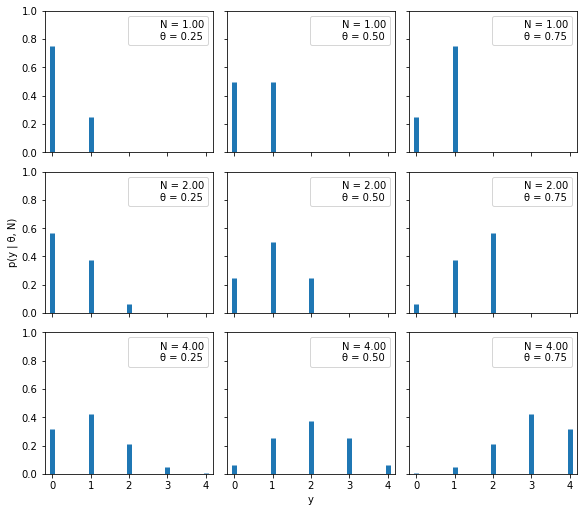

In [8]:
# Plot the Binomial likelihood

n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


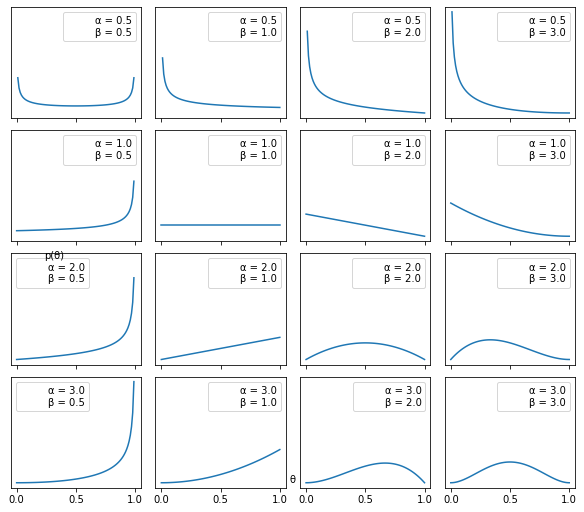

In [9]:
# Plot the beta prior

params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)


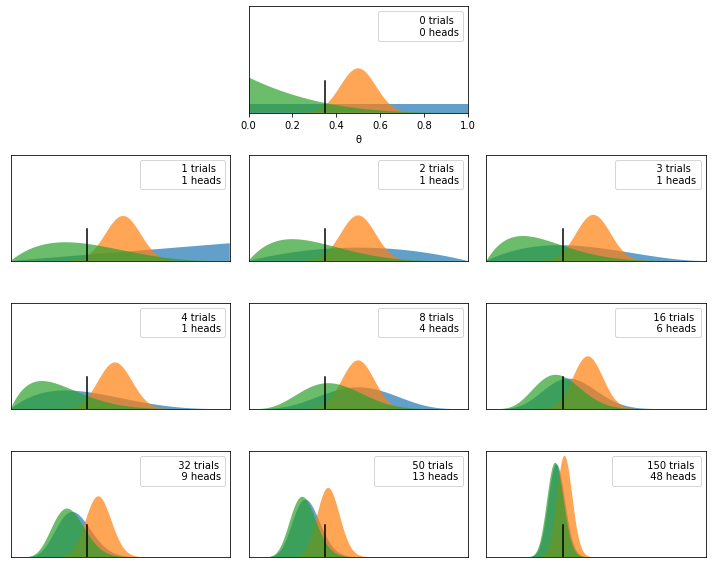

In [10]:
# Compute and plot posterior (black vertical line = true parameter value)

plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()


## Credible intervals <a class="anchor" id="credible"></a>




In [16]:
# We illustrate how to compute a 95% posterior credible interval for a random variable
# with a beta distribution.

from scipy.stats import beta

np.random.seed(42)
theta_real = 0.35
ntrials = 100
data = stats.bernoulli.rvs(p=theta_real, size=ntrials)

N = ntrials; N1 = sum(data); N0 = N-N1; # Sufficient statistics
aprior = 1; bprior = 1; # prior
apost = aprior + N1; bpost = bprior + N0 # posterior

# Interval function
alpha = 0.05
CI1 = beta.interval(1-alpha, apost, bpost)
print('{:0.2f}--{:0.2f}'.format(CI1[0], CI1[1])) # (0.06:0.52) 

# Use the inverse CDF (percent point function)
l  = beta.ppf(alpha/2, apost, bpost)
u  = beta.ppf(1-alpha/2, apost, bpost)
CI2 = (l,u)
print('{:0.2f}--{:0.2f}'.format(CI2[0], CI2[1])) # (0.06:0.52) 

# Use Monte Carlo sampling
samples = beta.rvs(apost, bpost, size=10000)
samples = np.sort(samples)
CI3 = np.percentile(samples, 100*np.array([alpha/2, 1-alpha/2])) 
print('{:0.2f}--{:0.2f}'.format(CI3[0], CI3[1])) # (0.06:0.51) 
print(np.mean(samples))


0.24--0.42
0.24--0.42
0.24--0.42
0.3230834644012448


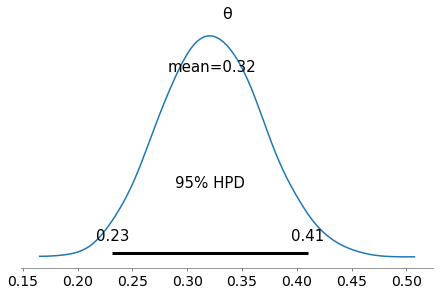

In [17]:
# The arviz package (https://github.com/arviz-devs/arviz) can be used to make plots
# of high posterior density intervals, as shown below.
# By default, it shows the 94\% interval, but we change it to 95%.

az.plot_posterior({'θ':samples}, credible_interval=0.95);



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f886bd68a20>],
      dtype=object)

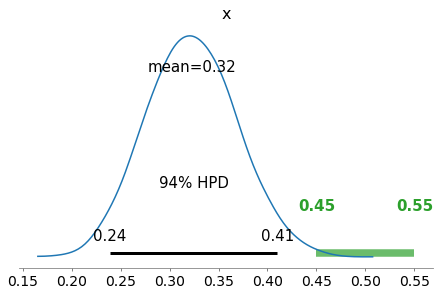

In [18]:
# See if the parameter is inside the region of practical equivalence centered at 0.5
az.plot_posterior(samples, rope=[0.45, .55])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f886ce412b0>],
      dtype=object)

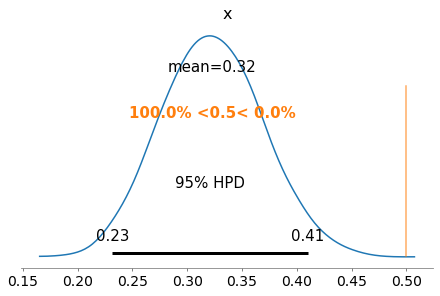

In [19]:
# From the above plot, we see that the HPD does not overlap the ROPE,
#so we can confidently say the parameter is "significiantly different" from 0.5

# We can also verify this by checking if 0.5 is in the HPD
az.plot_posterior(samples,  credible_interval=0.95, ref_val=0.5)

## Point estimates

We minimize the posterior expected loss, using L2 loss (estimator is posterior mean) or L1 loss (estimator is posterior median).

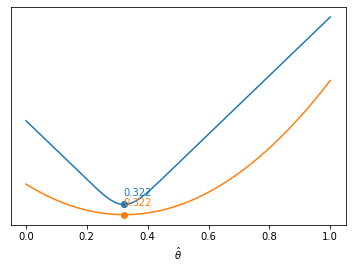

In [20]:
grid = np.linspace(0, 1, 200)
θ_pos = samples #trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.3f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

# MCMC inference for Beta-Binomial model

We will use pymc3 to approximate the posterior of this simple model.
Code is based on [this notebook](https://github.com/aloctavodia/BAP/blob/master/code/Chp202%20Programming%20probabilistically.ipynb).



In [21]:
data # same as above

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0])

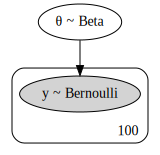

In [34]:
with pm.Model() as model:
    # a priori
    θ = pm.Beta('θ', alpha=aprior, beta=bprior)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data)

pm.model_to_graphviz(model) # show the DAG

In [35]:
# run MCMC (defaults to 2 chains)
with model:
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 1948.20it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88652de898>,
      dtype=object)

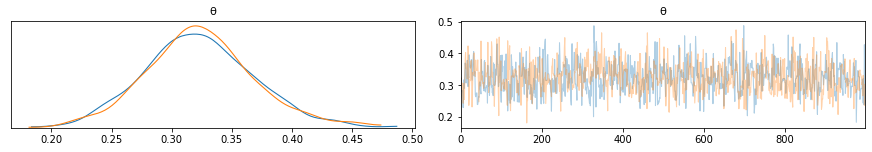

In [23]:
# Show trace plot to assess convergence
az.plot_trace(trace)


In [25]:
# Summarize  posterior samples
az.summary(trace)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.324,0.045,0.237,0.407,0.002,0.001,867.0,867.0,851.0,1292.0,1.01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8862c3a470>],
      dtype=object)

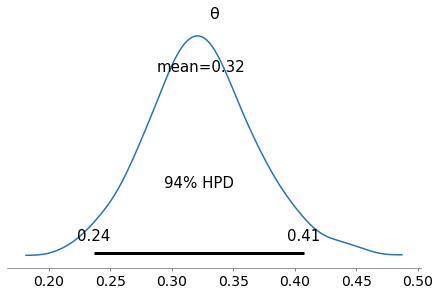

In [26]:
# The samples from MCMC (called "trace") should be similar to the exact
# iid samples from the posterior, plotted above
az.plot_posterior(trace)


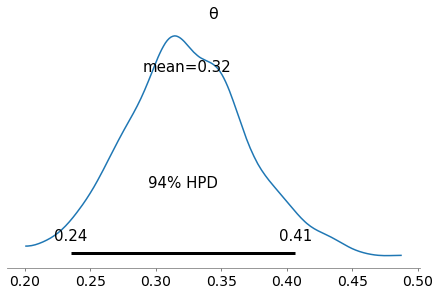

In [42]:
# Convert posterior samples into a parametric distribution
trace_approx = pm.Empirical(trace, model=model)
pm.plot_posterior(trace_approx.sample(1000));

# Variational inference for Beta-Binomial model

We use automatic differentiation VI.
Details can be found at https://docs.pymc.io/notebooks/variational_api_quickstart.html

In [38]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    post = pm.fit(method='advi', callbacks=[CheckParametersConvergence()]); # mean field approximation


Average Loss = 64.884: 100%|██████████| 10000/10000 [00:04<00:00, 2311.82it/s]
Finished [100%]: Average Loss = 64.883


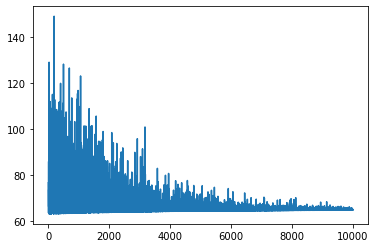

In [40]:
# Plot negative ELBO vs iteration to assess convergence
plt.plot(post.hist);

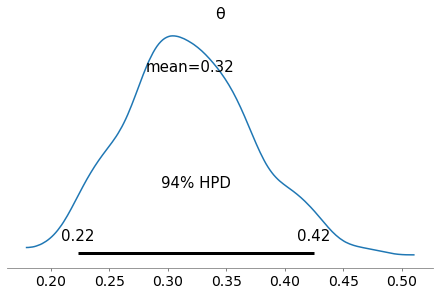

In [39]:
pm.plot_posterior(post.sample(1000));